Package Imports

In [ ]:
# Regular modules for data science and visualization:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Keras (2.2.4) and tensorflow (1.13).
import tensorflow as tf
import tensorflow_hub as hub
from keras.regularizers import l1, l2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend
from keras import optimizers
from keras.models import model_from_json
import os

#sklearn and imblearn modules:
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn import model_selection, svm

#csv reading fixes
import sys
import csv
csv.field_size_limit(sys.maxsize)

from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Mounted at /content/drive


In [ ]:
e_All = np.array(pd.read_csv('/content/drive/MyDrive/SeniorDesignFiles/vectors.csv', header=None))

In [ ]:
# import csvs into 1 df and only keep needed data
df1 = pd.read_csv('/content/drive/MyDrive/SeniorDesignFiles/articles1.1.csv', engine='python', error_bad_lines=False)
df2 = pd.read_csv('/content/drive/MyDrive/SeniorDesignFiles/articles2.1.csv', engine='python', error_bad_lines=False)
df3 = pd.read_csv('/content/drive/MyDrive/SeniorDesignFiles/articles3.1.csv', engine='python', error_bad_lines=False)
df = df1.append([df2, df3], sort=False)[['publication', 'content']]
df = df[df['publication'] != 'Talking Points Memo']

In [ ]:
#Label data based on bias
publisher_dict ={'Atlantic': 2,
                 'Breitbart': 5,
                 'Business Insider': 3,
                 'Buzzfeed News': 1,
                 'CNN': 2,
                 'Fox News': 4,
                 'Guardian': 2,
                 'NPR': 3,
                 'National Review': 5,
                 'New York Post': 4,
                 'New York Times': 2,
                 'Reuters': 3,
                 'Vox': 1,
                 'Washington Post': 2}

df['label'] = df['publication'].apply(lambda x: publisher_dict[x])

In [ ]:
# remove all instances of publisher names from content
n_s = list(df['content'])
for key in publisher_dict.keys():
  n_s = [word.replace(key,'') for word in n_s]

# get classes of all elements
classes_All = np.asarray(df['label'])

In [ ]:
dic = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0}
for i in classes_All:
  dic[i] += 100/len(classes_All)

In [ ]:
class_weights = {}
for i in dic.keys():
  class_weights[i-1] = 1/dic[i]/0.3251363864853185

class_weights

{0: 0.4310247271244633,
 1: 0.09131627146571636,
 2: 0.14340179064285363,
 3: 0.19336629059127836,
 4: 0.14089092017568816}

In [ ]:

# Load the encoder:
g = tf.Graph()
with g.as_default():
  text_input = tf.compat.v1.placeholder(dtype=tf.string, shape=[None])
  embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-large/3")
  embedded_text = embed(text_input)
  init_op = tf.group([tf.compat.v1.global_variables_initializer(), tf.compat.v1.tables_initializer()])
g.finalize()

# Initialize session:
session = tf.compat.v1.Session(graph=g)
session.run(init_op)

# Function to compute all embeddings for each sentence (takes a while)
def similarity_matrix(merge_list):
    #initialize distance array:
    #initialize embeddings array:
    emb_all = np.zeros([len(merge_list),512])
    #Outer for loop:
    per = 0
    for i in range(0,len(merge_list)):
        #Here is where we run the previously started session, so it is important to run previous step succesfully:
        i_emb = session.run(embedded_text, feed_dict={text_input: [merge_list[i]]})
        emb_all[i,:] = i_emb
        if i % 10**4 == 0:
          print(int(i / len(merge_list) * 100))
    return emb_all

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
e_All = similarity_matrix(n_s)
# Save to csv as this step takes so long
np.savetxt("vectors.csv", np.asarray(e_All), delimiter=",")

Building Model

In [ ]:
#Choose optimizer:
optim = optimizers.Adam(lr=0.00015) 

# create NN for news clissification:
news_DNN = Sequential()
news_DNN.add(Dense(40, input_dim=512, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))
news_DNN.add(Dense(40, activation = 'relu',kernel_regularizer=l2(0.1)))
news_DNN.add(Dropout(0.25))

# Output layer with multiclass activation function:
news_DNN.add(Dense(5,activation='softmax'))
# Compile model:
news_DNN.compile(loss='sparse_categorical_crossentropy', optimizer=optim, metrics=['acc'])

In [ ]:
# split into shuffled folds
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.33) # chose one split to make analysis faster. change it if required
scaler = StandardScaler()
for t, te in sss.split(e_All, classes_All):
  # Scale the data with StandardScaler before splitting:
  X_train, X_test = scaler.fit_transform(e_All)[t], \
  scaler.fit_transform(e_All)[te]
  y_train, y_test = classes_All[t]-1, classes_All[te]-1

Train model

In [ ]:
#fit the network.
m_h = news_DNN.fit(X_train, y_train, epochs=200, \
validation_data=(X_test, y_test), batch_size=32, verbose=1) # class_weight=class_weights

Epoch 1/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.3158 - acc: 0.4823 - val_loss: 1.2436 - val_acc: 0.5176
Epoch 2/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2895 - acc: 0.4996 - val_loss: 1.2411 - val_acc: 0.5181
Epoch 3/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2841 - acc: 0.5036 - val_loss: 1.2387 - val_acc: 0.5251
Epoch 4/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2827 - acc: 0.5037 - val_loss: 1.2277 - val_acc: 0.5286
Epoch 5/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2804 - acc: 0.5049 - val_loss: 1.2358 - val_acc: 0.5222
Epoch 6/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2773 - acc: 0.5049 - val_loss: 1.2288 - val_acc: 0.5256
Epoch 7/200
2876/2876 [==============================] - 6s 2ms/step - loss: 1.2789 - acc: 0.5049 - val_loss: 1.2267 - val_acc: 0.5258
Epoch 8/200
2876/2876 [==============================] 

Visualization

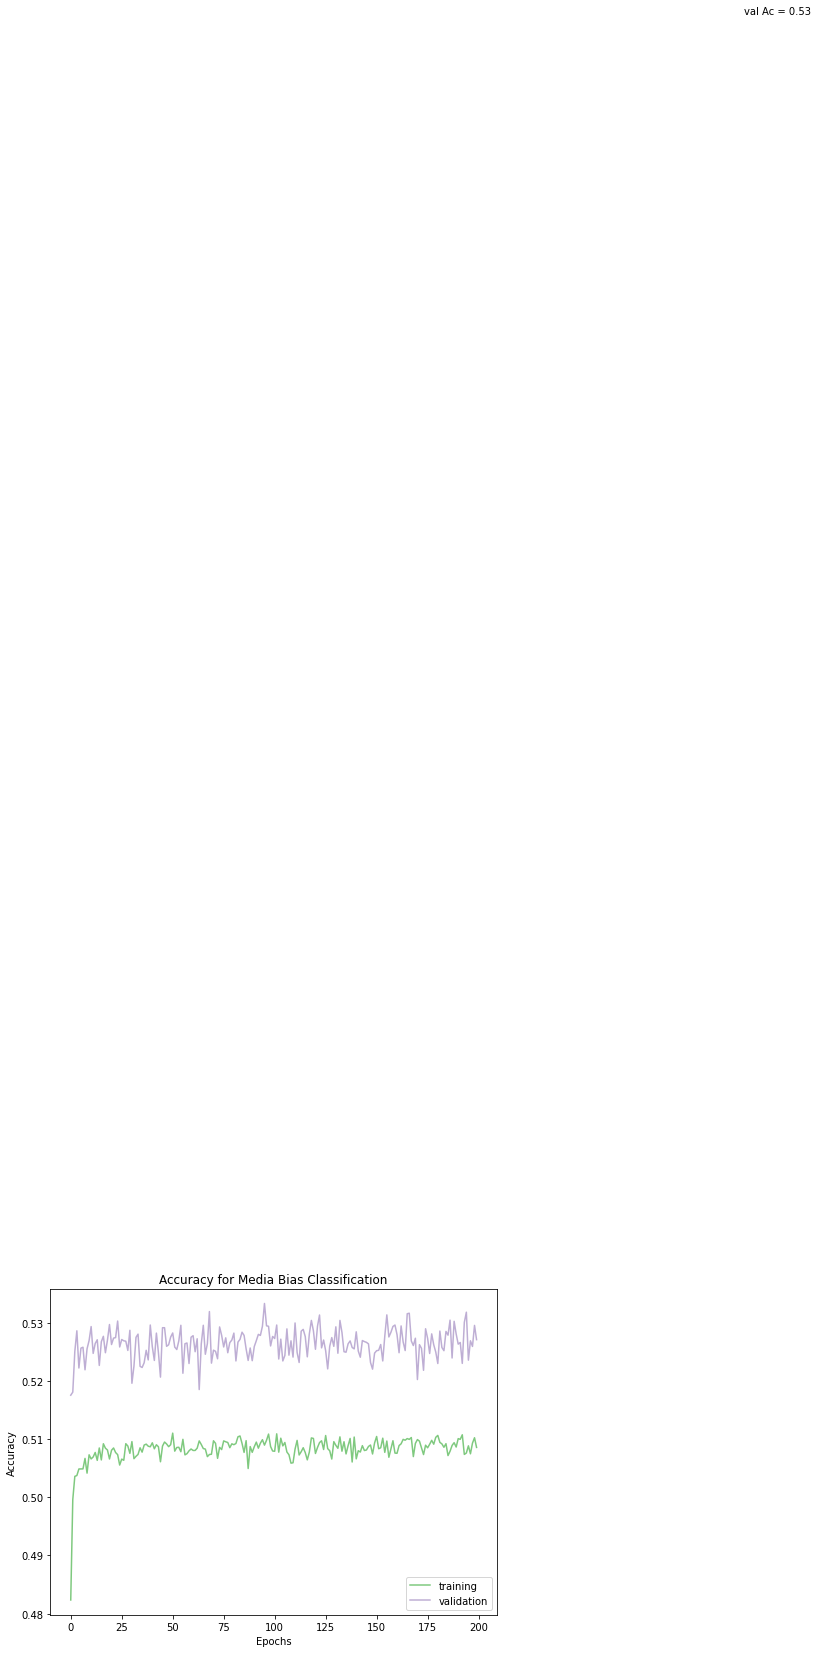

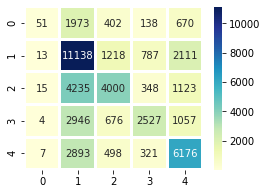

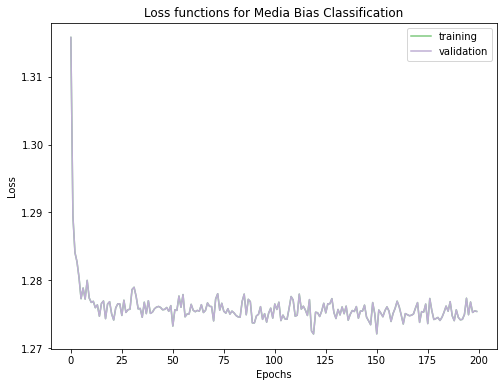

In [ ]:
# Plot accuracy curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['acc']))
    sns.lineplot(data=np.asarray(m_h.history['val_acc']))
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy for Media Bias Classification")
    plt.legend(labels=['training', 'validation'],loc='lower right')
    plt.text(330,0.755,'val Ac = ' + str(round(metrics.accuracy_score(y_test, np.argmax(news_DNN.predict(X_test), axis=-1)),2))) 
    plt.savefig('outlets_bias_acc.svg',format='svg')

# Plot confusion matrix:
plt.figure(figsize=(4, 3))
sns.heatmap(metrics.confusion_matrix(y_test, np.argmax(news_DNN.predict(X_test), axis=-1)),\
annot=True,linewidths=2, cmap="YlGnBu",fmt="g", \
xticklabels=list([i for i in range(5)]),\
yticklabels=list([i for i in range(5)]))
plt.autoscale()
# plt.savefig('confusion_matrix_outlet_bias_bal.png',format='PNG',bbox_inches = "tight")

# Plot loss curves:
with sns.color_palette("Accent", n_colors=8):
    plt.figure(figsize=(8,6))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    sns.lineplot(data=np.asarray(m_h.history['loss']))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss functions for Media Bias Classification")
    plt.legend(labels=['training', 'validation'])
    # plt.savefig('outlets_bias_loss.svg',format='SVG') 

In [ ]:
# saving model to json file
model_json = news_DNN.to_json()
with open("model1.json", "w") as json_file:
    json_file.write(model_json)≤
# serialize weights to HDF5
news_DNN.save_weights("model1.h5")

In [ ]:
#
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [ ]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
print("fitting now")
SVM.fit(X_train,y_train)
# predict the labels on validation dataset
print("predicting now")
predictions_SVM = SVM.predict(X_test)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)